# Compare ATL06-SR to SNOTEL snow depth measurements 
## Calculate:  
* median difference,
* RMSE,
* standard deviation

### Import necessary packages:

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime
import pickle
from scipy import stats

In [2]:
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)

In [10]:
mpl_epoch = '1970-01-01'

In [11]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Load in the data:

In [13]:
#atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed.pkl', 'rb'))
#atl06sr_gdf = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic.pkl', 'rb'))
atl06sr_gdf = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic_7912.pkl', 'rb'))

outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_32610.pkl', 'rb'))
methow_reverse = pickle.load(open('../../data/site_outlines/methow_reverse.pkl', 'rb'))

snwd = pickle.load(open('../data/snotel/snotel_snwd_35.pkl', 'rb'))
snotel_sites = pickle.load(open('../data/snotel/snotel_sites_65.pkl', 'rb'))
snotel_geom = pickle.load(open('../data/snotel/snotel_geometries.pkl', 'rb'))

cso_methow = pickle.load(open('../../data/cso/cso-data.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_7158/122870617.py:5: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_32610.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_7158/122870617.py:7: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  methow_reverse = pickle.load(open('../../data/site_outlines/methow_reverse.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_7158/122870617.py:11: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  snotel_sites = pickle.load(open('../data/snotel/snotel_sites_65.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_7158/122870617.py:13: UserWarning: Unpickl

In [14]:
#atl06sr_gdf = atl06sr_gdf.rename(columns={'diff_plus_bicubic_update':'diff_plus_bicubic'})

### Remove outliers:

In [17]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [18]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [21]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

In [53]:
atl06sr_gdf['snow_presence'] = atl06sr_gdf['snow_presence'].astype(str).astype(int)

### Calculate the mode:

In [23]:
counts = stats.binned_statistic(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['difference_bicubic'], 
                       atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['difference_bicubic'], 'count', 
                       bins=int(np.sqrt(len(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['difference_bicubic']))))

print("Maximum count within a bin:", counts[0].max())
print("Bin edges of the bin with maximum count:", counts[1][np.where(counts[0]==counts[0].max())[0]], "-", counts[1][np.where(counts[0]==counts[0].max())[0]+1])

Maximum count within a bin: 1641.0
Bin edges of the bin with maximum count: [0.02723238] - [0.05100545]


### Make a comparison table of summary statistics:

In [54]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
        
    comp_table_all['stdev'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'stdev'] = np.std(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus_bicubic'].count()
    
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['muck_depth'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'muck_depth'] = snwd[snwd.index == date]['Muckamuck']
    
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['salm_depth'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'salm_depth'] = snwd[snwd.index == date]['Salmon Meadows']
    
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-muck_diff'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-muck_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'muck_depth']
    
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-muck_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-muck_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-muck_diff'] / comp_table_all.loc[comp_table_all.index==date,'muck_depth']) * 100
    
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-salm_diff'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-salm_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'salm_depth']
    
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-salm_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-salm_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-salm_diff'] / comp_table_all.loc[comp_table_all.index==date,'salm_depth']) * 100
    
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['snotel_mean'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snotel_mean'] = (comp_table_all.loc[comp_table_all.index==date,'muck_depth'] + comp_table_all.loc[comp_table_all.index==date,'salm_depth']) / 2
    
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-snotel_mean'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'snotel_mean']
    
    comp_table_all['atl06-snotel_mean_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean'] / comp_table_all.loc[comp_table_all.index==date,'snotel_mean']) * 100
    
    comp_table_all['rmse_inner_muck'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'muck_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_inner_muck'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
        
    comp_table_all['rmse_inner_salm'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'salm_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_inner_salm'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
    
    comp_table_all['mae_inner_muck'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(atl06sr_gdf.loc[atl06sr_gdf.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'muck_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_muck'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_df['acqdate']==date.date(), 'mae_inner_muck'] = np.nan
    
    comp_table_all['mae_inner_salm'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(atl06sr_gdf.loc[atl06sr_gdf.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'salm_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_salm'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_salm'] = np.nan
    
    comp_table_all['snow_presence'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==date.date(), 'snow_presence'])
    
    return comp_table_all

In [55]:
comp_df = make_comparison_table(atl06sr_gdf_inner)

# Calculate RMSE and MAE

## RMSE

In [28]:
squared_dif = np.sum((comp_df['median'] - comp_df['muck_depth'])**2)
rmse_all_muck = np.sqrt(squared_dif/comp_df['muck_depth'].count())
print('Basin RMSE Muck:', rmse_all_muck)

Basin RMSE Muck: 0.24906238430548336


In [56]:
squared_dif = np.sum((comp_df[comp_df['snow_presence']==1]['median'] - comp_df[comp_df['snow_presence']==1]['muck_depth'])**2)
rmse_all_snowon_muck = np.sqrt(squared_dif/comp_df[comp_df['snow_presence']==1]['muck_depth'].count())
print('Basin RMSE snow on Muck:', rmse_all_snowon_muck)

Basin RMSE snow on Muck: 0.33177002355533963


In [30]:
squared_dif = np.sum((comp_df['median'] - comp_df['salm_depth'])**2)
rmse_all_salm = np.sqrt(squared_dif/comp_df['salm_depth'].count())
print('Basin RMSE Salm:', rmse_all_salm)

Basin RMSE Salm: 0.29582601258248276


In [57]:
squared_dif = np.sum((comp_df[comp_df['snow_presence']==1]['median'] - comp_df[comp_df['snow_presence']==1]['salm_depth'])**2)
rmse_all_snowon_salm = np.sqrt(squared_dif/comp_df[comp_df['snow_presence']==1]['salm_depth'].count())
print('Basin RMSE snow on Salm:', rmse_all_snowon_salm)

Basin RMSE snow on Salm: 0.41133427354995805


In [63]:
squared_dif = np.sum((comp_df['median'] - comp_df['snotel_mean'])**2)
rmse_all_snotel_mean = np.sqrt(squared_dif/comp_df['snotel_mean'].count())
print('Basin RMSE Snotel Mean:', rmse_all_snotel_mean)

Basin RMSE Snotel Mean: 0.2693462582341221


## MAE

In [33]:
abs_dif_sum = np.sum(abs(comp_df['median'] - comp_df['muck_depth']))
mae_all_muck = abs_dif_sum/comp_df['muck_depth'].count()
print('Basin MAE Muck:', mae_all_muck)

Basin MAE Muck: 0.1870949671075445


In [34]:
abs_dif_sum = np.sum(abs(comp_df['median'] - comp_df['salm_depth']))
mae_all_salm = abs_dif_sum/comp_df['salm_depth'].count()
print('Basin MAE Salm:', mae_all_salm)

Basin MAE Salm: 0.22272488785027847


In [35]:
abs_dif_sum = np.sum(abs(comp_df['median'] - comp_df['snotel_mean']))
mae_all_snotel_mean = abs_dif_sum/comp_df['snotel_mean'].count()
print('Basin MAE Salm:', mae_all_snotel_mean)

Basin MAE Salm: 0.20354529601354376


## Calculate and print the median differences between ATL06-SR snow depth and SNOTEL snow depth:

#### Compared to Muckamuck:

In [32]:
# All differences
print(np.nanmedian(comp_df['atl06-muck_diff'].abs()))
print(np.nanmedian(comp_df['atl06-muck_diff']))

0.1401850324559269
-0.06637760536978021


In [33]:
# Only snow-on differences
print(np.nanmedian(comp_df[comp_df['snow_presence']==1]['atl06-muck_diff'].abs()))
print(np.nanmedian(comp_df[comp_df['snow_presence']==1]['atl06-muck_diff']))

0.25167779403967433
-0.1950644073603387


In [44]:
comp_df[comp_df['snow_presence']==1]['atl06-muck_diff'].describe()

count    19.000000
mean     -0.211047
std       0.263004
min      -0.833854
25%      -0.393318
50%      -0.195064
75%      -0.081331
max       0.275489
Name: atl06-muck_diff, dtype: float64

#### Compared to Salmon Meadow:

In [58]:
print(np.nanmedian(comp_df[comp_df['snow_presence']==1]['atl06-salm_diff'].abs()))
print(np.nanmedian(comp_df[comp_df['snow_presence']==1]['atl06-salm_diff']))

0.3252999085984333
-0.3252999085984333


In [27]:
comp_df['median_slope30t40d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<40) & (atl06sr_gdf['slope_20m']>30),'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6210/2057982061.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<40) & (atl06sr_gdf['slope_20m']>30),'diff_plus'])
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [28]:
np.nanmedian(comp_df['median_slope30t40d'].abs())

0.7541783120676655

In [29]:
comp_df['median_slope0t10d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope0t10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6210/3679506861.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope0t10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [30]:
np.nanmedian(comp_df['median_slope0t10d'].abs())

0.13930502102840592

In [366]:
atl06sr_gdf.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy,snow_presence,lidar_z,difference,lidar_z_20m,difference_20m,slope_3m,slope_20m,slope_100m,diff_plus,diff_plus_20m,zscore,n,diff_plus_lowslope
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1468.0,NaN
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40,0,921.263184,-1.321359,924.401428,-4.459604,21.903059,11.596403,NaN,-0.881577,-4.024133,-0.667243,1468.0,-0.968813


In [367]:
np.nanmedian(atl06sr_gdf[atl06sr_gdf['snow_presence']==1]['diff_plus'])

0.1777582017409145

In [22]:
comp_df.n.max()

11845.0

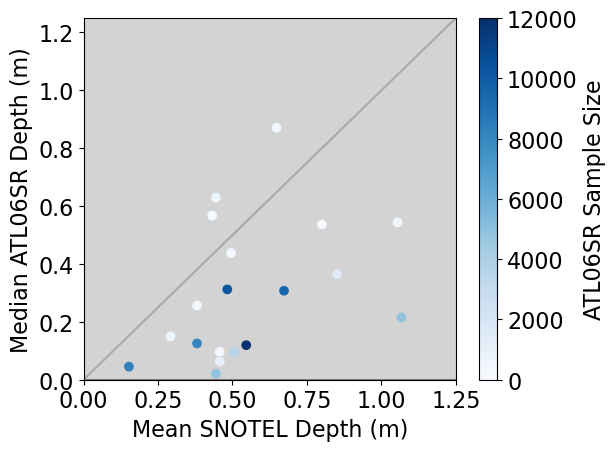

In [24]:
x = np.linspace(-0.7,3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_df[comp_df['snow_presence']==1]['snotel_mean'], comp_df[comp_df['snow_presence']==1]['median'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues', vmin=0, vmax=12000)
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(0), ymax=1.5, color='grey')
plt.axhline(y=0, xmin=(0), xmax=1.5, color='grey')
plt.colorbar(c, label='ATL06SR Sample Size')
plt.ylim(0, 1.25)
plt.xlim(0, 1.25)
plt.xlabel('Mean SNOTEL Depth (m)')
plt.ylabel('Median ATL06SR Depth (m)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
#plt.savefig('../../figures/polished/median_dif_vs_delta_snotel.jpeg', dpi=500)

#### Standard deviation of snow-on and snow-off ATL06-SR values:

In [370]:
np.nanstd(atl06sr_gdf[atl06sr_gdf['snow_presence']==1]['diff_plus'])

1.212294028291108

In [371]:
np.nanstd(atl06sr_gdf[atl06sr_gdf['snow_presence']==0]['diff_plus'])

1.1939543798429277

#### Plot the ATL06-SR colored by sampled size:

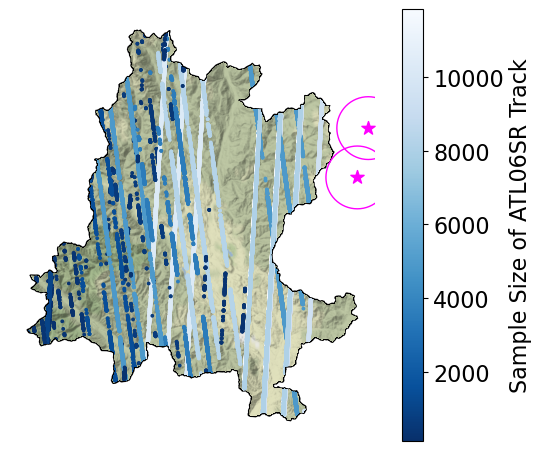

In [307]:
basemap = cx.providers.Stamen.TerrainBackground

fig, ax = plt.subplots()

atl06sr_gdf[atl06sr_gdf['snow_presence']==1].plot(column='n', cmap='Blues_r', ax=ax, markersize=3, legend=True, legend_kwds={'label':'Sample Size of ATL06SR Track'})
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')
cx.add_basemap(ax=ax, attribution=False, crs='epsg:32610', source=basemap, zoom=11)
methow_reverse.plot(ax=ax, facecolor='white')
snotel_geom[0:2].plot(ax=ax, color='magenta', marker='*', markersize=100)
snotel_geom[2:].plot(ax=ax, facecolor='none',edgecolor='magenta')
ax.set_axis_off()
plt.tight_layout()
#plt.savefig('../../figures/date_offset_map.jpeg', dpi=300)

### Add Slope Metrics, for comparison to previous studies:

In [22]:
comp_df['median_slope20d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==date) 
                                                                & (atl06sr_gdf_inner['slope_20m']>20),'diff_plus_bicubic'])


/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [23]:
comp_df['median_diff_slope20d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_diff_slope20d'] = comp_df['median_slope20d'] - comp_df['snotel_mean']

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [60]:
np.nanmedian(comp_df['median_diff_slope20d'])

-0.5053891339636698

In [25]:
comp_df['median_slope0t5d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope0t5d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==date) & 
                                                                    (atl06sr_gdf_inner['slope_20m']<5),'diff_plus_bicubic'])


/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [26]:
comp_df['median_diff_slope0t5d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_diff_slope0t5d'] = comp_df['median_slope0t5d'] - comp_df['snotel_mean']

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [59]:
np.nanmedian(comp_df['median_diff_slope0t5d'])

0.07539802579910315

In [98]:
comp_df['median_slope25t30d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope25t30d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==date) & 
                                                                    (atl06sr_gdf_inner['slope_20m']<30) &(atl06sr_gdf_inner['slope_20m']>25),'diff_plus_bicubic'])


/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [105]:
scipy.stats.median_abs_deviation(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0) &
    (atl06sr_gdf_inner['slope_20m']<30) &
    (atl06sr_gdf_inner['slope_20m']>25),'diff_plus_bicubic'])


0.8714801247241439

In [108]:
np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0) &
    (atl06sr_gdf_inner['slope_20m']<30) &
    (atl06sr_gdf_inner['slope_20m']>25),'diff_plus_bicubic'])

-0.4929626630494113

In [106]:
scipy.stats.median_abs_deviation(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0) &
    (atl06sr_gdf_inner['slope_20m']<5),'diff_plus_bicubic'])


0.1308935579994568

In [107]:
np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0) &
    (atl06sr_gdf_inner['slope_20m']<5),'diff_plus_bicubic'])

0.10267423859568225

In [99]:
comp_df['median_diff_slope25t30d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_diff_slope25t30d'] = comp_df['median_slope25t30d'] - comp_df['snotel_mean']

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [100]:
np.nanmedian(comp_df['median_diff_slope25t30d'])

-0.5793116696988818

In [ ]:
atl06sr_gdf_inner['diff_plus_bicubic_from_aso'] = atl06sr_gdf_inner['diff_plus_bicubic'] - atl06sr_gdf_inner['ASO_snowon_bic']

## Compute a similar data table within the radii:

In [73]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
        
    comp_table_all['stdev'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'stdev'] = np.std(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus_bicubic'].count()
    
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['muck_depth'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'muck_depth'] = snwd[snwd.index == date]['Muckamuck']
    
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['salm_depth'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'salm_depth'] = snwd[snwd.index == date]['Salmon Meadows']
    
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-muck_diff'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-muck_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'muck_depth']
    
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-muck_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-muck_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-muck_diff'] / comp_table_all.loc[comp_table_all.index==date,'muck_depth']) * 100
    
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-salm_diff'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-salm_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'salm_depth']
    
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-salm_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-salm_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-salm_diff'] / comp_table_all.loc[comp_table_all.index==date,'salm_depth']) * 100
    
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['snotel_mean'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snotel_mean'] = (comp_table_all.loc[comp_table_all.index==date,'muck_depth'] + comp_table_all.loc[comp_table_all.index==date,'salm_depth']) / 2
    
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-snotel_mean'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'snotel_mean']
    
    comp_table_all['atl06-snotel_mean_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean'] / comp_table_all.loc[comp_table_all.index==date,'snotel_mean']) * 100
    
    #make sure I use the atl06_inner dataframe here
    comp_table_all['rmse_inner_muck'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'muck_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_inner_muck'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
        
    comp_table_all['rmse_inner_salm'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'salm_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_inner_salm'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
    
    comp_table_all['mae_inner_muck'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'muck_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_muck'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_df['acqdate']==date.date(), 'mae_inner_muck'] = np.nan
    
    comp_table_all['mae_inner_salm'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'salm_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_salm'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_salm'] = np.nan
    
    comp_table_all['snow_presence'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==date.date(), 'snow_presence'])
    
    return comp_table_all

In [36]:
snotel_geom = snotel_geom.to_crs('epsg:7912')

In [74]:
comp_muckradius = make_comparison_table(atl06sr_gdf_inner.loc[atl06sr_gdf_inner.within(snotel_geom.loc[2, 'geometry'])])

In [76]:
comp_salmradius = make_comparison_table(atl06sr_gdf_inner.loc[atl06sr_gdf_inner.within(snotel_geom.loc[3, 'geometry'])])

In [328]:
comp_muckradius = comp_muckradius.drop(columns=['atl06-salm_diff', 'atl06-salm_percent', 'salm_depth'])

In [331]:
comp_salmradius = comp_salmradius.drop(columns=['muck_depth', 'atl06-muck_diff', 'atl06-muck_percent'])

#### Save to csv as a backup:

In [332]:
comp_muckradius.to_csv('../../figures/comp_muckradius.csv')
comp_salmradius.to_csv('../../figures/comp_salmradius.csv')

#### Plot the differences for the whole basin and just within the radii:

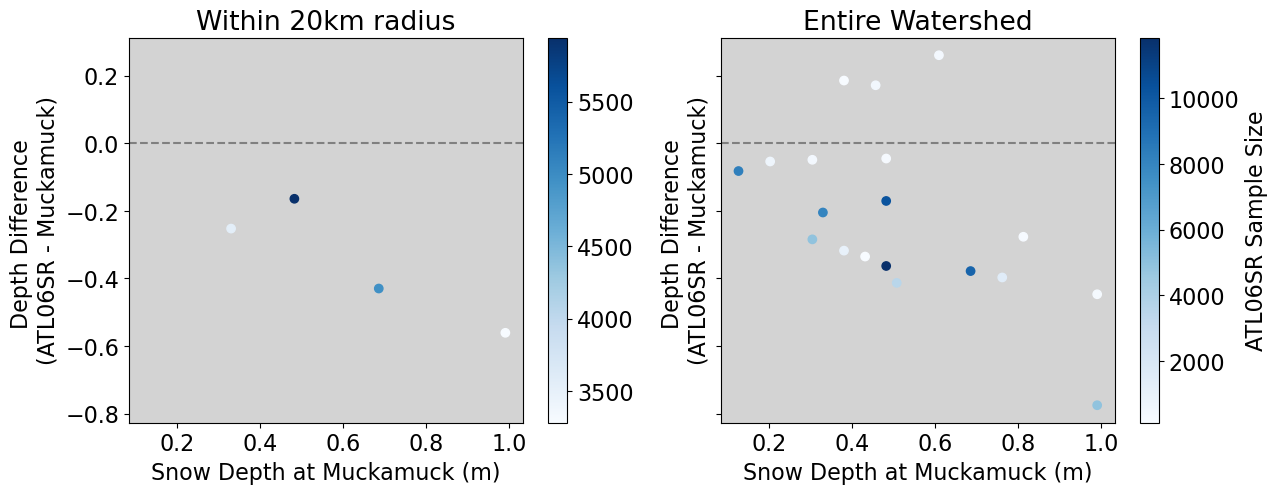

In [345]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_muckradius[comp_muckradius['snow_presence']==1]['muck_depth'], comp_muckradius[comp_muckradius['snow_presence']==1]['atl06-muck_diff'], c=comp_muckradius[comp_muckradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at Muckamuck (m)')
ax[0].set_ylabel('Depth Difference \n(ATL06SR - Muckamuck)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 20km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['muck_depth'], comp_df[comp_df['snow_presence']==1]['atl06-muck_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at Muckamuck (m)')
ax[1].set_ylabel('Depth Difference \n(ATL06SR - Muckamuck)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

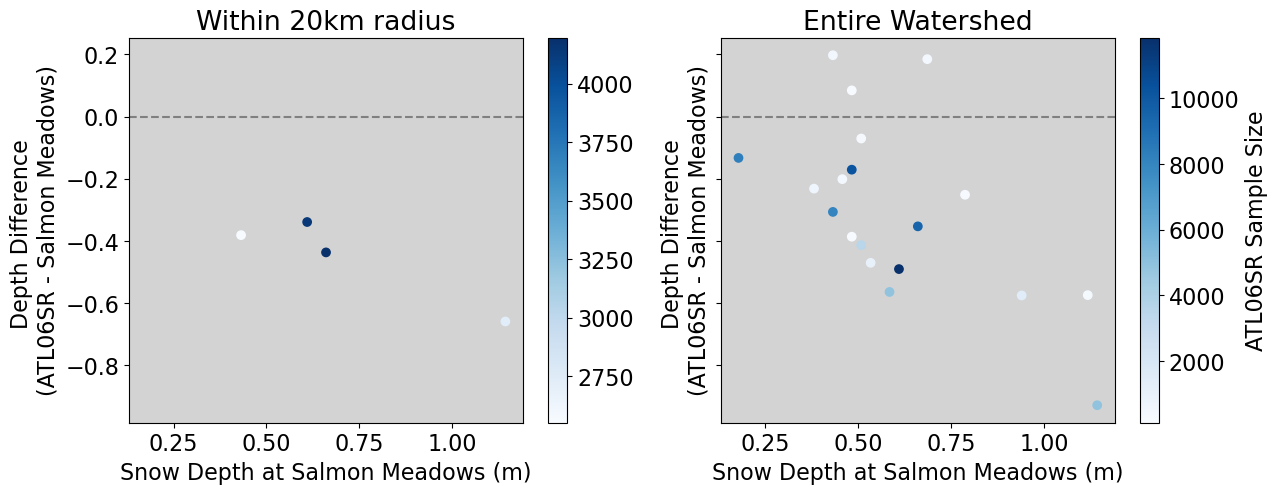

In [346]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_salmradius[comp_salmradius['snow_presence']==1]['salm_depth'], comp_salmradius[comp_salmradius['snow_presence']==1]['atl06-salm_diff'], c=comp_salmradius[comp_salmradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at Salmon Meadows (m)')
ax[0].set_ylabel('Depth Difference \n(ATL06SR - Salmon Meadows)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 20km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['salm_depth'], comp_df[comp_df['snow_presence']==1]['atl06-salm_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at Salmon Meadows (m)')
ax[1].set_ylabel('Depth Difference \n(ATL06SR - Salmon Meadows)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

In [77]:
np.nanmedian(comp_muckradius.loc[comp_muckradius['snow_presence']==1,'atl06-muck_diff'])

-0.41487620357772403

In [78]:
np.nanmedian(comp_salmradius.loc[comp_salmradius['snow_presence']==1,'atl06-salm_diff'])

-0.46446225481919096

#### Print out summary statistis:

In [56]:
for data in [(comp_df[comp_df['snow_presence']==1]['iqr']), 
             comp_df[comp_df['snow_presence']==1]['atl06-muck_diff'], \
             comp_df[comp_df['snow_presence']==1]['atl06-muck_percent'], 
             comp_df[comp_df['snow_presence']==1]['atl06-salm_diff'], \
            comp_df[comp_df['snow_presence']==1]['atl06-salm_percent'],
             comp_df[comp_df['snow_presence']==1]['stdev'],
             comp_muckradius[comp_muckradius['snow_presence']==1]['iqr'], \
            comp_muckradius[comp_muckradius['snow_presence']==1]['atl06-muck_diff'], 
             comp_muckradius[comp_muckradius['snow_presence']==1]['atl06-muck_percent'], \
             comp_muckradius[comp_muckradius['snow_presence']==1]['stdev'],
            comp_salmradius[comp_salmradius['snow_presence']==1]['atl06-salm_diff'], 
             comp_salmradius[comp_salmradius['snow_presence']==1]['atl06-salm_percent'], \
            comp_salmradius[comp_salmradius['snow_presence']==1]['iqr'],
            comp_salmradius[comp_salmradius['snow_presence']==1]['stdev']]:
    print(f'{data.name}', 'median =', np.nanmedian(data))

iqr median = 1.0779997232249912
atl06-muck_diff median = -0.1950644073603387
atl06-muck_percent median = -45.174712218698176
atl06-salm_diff median = -0.3252999085984333
atl06-salm_percent median = -54.50561978467706
stdev median = 1.030567445706418
iqr median = 1.3579633628775696
atl06-muck_diff median = -0.41487620357772403
atl06-muck_percent median = -70.71643144532781
stdev median = 1.0472498801030063
atl06-salm_diff median = -0.46446225481919096
atl06-salm_percent median = -73.14376215657951
iqr median = 1.3369287754053403
stdev median = 1.035524071537993


## RMSE within radius:

In [79]:
squared_dif = np.sum((comp_muckradius[comp_muckradius['snow_presence']==1]['median'] - comp_muckradius[comp_muckradius['snow_presence']==1]['muck_depth'])**2)
rmse_radius_snowon_muck = np.sqrt(squared_dif/comp_muckradius[comp_muckradius['snow_presence']==1]['muck_depth'].count())
print('Radius RMSE snow on muck:', rmse_radius_snowon_muck)

Radius RMSE snow on muck: 0.4879921733295942


In [80]:
squared_dif = np.sum((comp_salmradius[comp_salmradius['snow_presence']==1]['median'] - comp_salmradius[comp_salmradius['snow_presence']==1]['salm_depth'])**2)
rmse_radius_snowon_salm = np.sqrt(squared_dif/comp_salmradius[comp_salmradius['snow_presence']==1]['salm_depth'].count())
print('Radius RMSE snow on salm:', rmse_radius_snowon_salm)

Radius RMSE snow on salm: 0.5516263930344503


## MAE within radius:

In [50]:
abs_dif_sum = np.sum(abs(comp_muckradius['median'] - comp_muckradius['muck_depth']))
mae_radius_muck = abs_dif_sum/comp_muckradius['muck_depth'].count()
print('Radius MAE muck:', mae_radius_muck)

Radius MAE muck: 0.24305916102671066


In [51]:
abs_dif_sum = np.sum(abs(comp_salmradius['median'] - comp_salmradius['salm_depth']))
mae_radius_salm = abs_dif_sum/comp_salmradius['salm_depth'].count()
print('Radius MAE salm:', mae_radius_salm)

Radius MAE salm: 0.20569028234254372
